## 2.1 Entity Name Recognition with BERT

In this section, we will train a BERT model for the task of entity name recognition. We will use the `transformers` library from Hugging Face, which provides pre-trained models and tokenizers for various NLP tasks.

In [ ]:
import pandas as pd
import warnings
import ast
import nltk
import numpy as np
from transformers import AutoTokenizer

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# download the punkt tokenizer
nltk.download('punkt')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# sample 3 percent of the data
df = df.sample(frac=0.03, random_state=42)

# preview the data
display(df.head())

[nltk_data] Downloading package punkt to C:\Users\Khor Kean
[nltk_data]     Teng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
1133,53085,68,Male,Post-surgical recovery (hip replacement).,True,2023-10-27T08:30:00Z,95.0,130.0,80.0,94.0,...,0,0,0,0,0,0,0,4,2,2
425,ebad9,78,Female,Congestive heart failure and chronic kidney di...,True,2023-10-26T10:45:00Z,110.0,160.0,95.0,90.0,...,0,0,1,0,0,0,0,5,1,1
78,b3450,63,Female,"Hypothyroidism, managed with medication. Recen...",True,2023-10-27T11:25:00Z,90.0,135.0,88.0,96.0,...,0,0,0,0,0,0,0,4,2,1
803,bba2a,38,Male,History of seasonal allergies. Presenting with...,False,2023-10-26T15:15:00Z,75.0,122.0,78.0,98.0,...,0,0,0,0,0,0,0,2,4,3
590,b31ea,49,Male,No known medical issues.,False,2023-10-27T19:00:00Z,68.0,118.0,77.0,99.0,...,0,0,0,0,0,0,0,1,5,4


### 2.1.1 Data Preprocessing

We will need to prepare our data for training so that the disease names are labeled correctly. We will use the `transformers` library to tokenize our text and create the necessary input format for BERT.

In [24]:
# select the necessary columns
df = df[['medical_history', 'extracted_diseases']]

# preview the data
display(df.head())

,medical_history,extracted_diseases
1133,Post-surgical recovery (hip replacement).,['hip replacement']
425,Congestive heart failure and chronic kidney di...,"['Congestive heart failure', 'chronic kidney d..."
78,"Hypothyroidism, managed with medication. Recen...","['Hypothyroidism', 'joint pain', 'fever']"
803,History of seasonal allergies. Presenting with...,"['seasonal allergies', 'allergy']"
590,No known medical issues.,[]


In [25]:
# Convert string representation of list to actual list
df['extracted_diseases'] = df['extracted_diseases'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Create BIO tagging schema for NER

In [26]:
def create_bio_tags(text, entities):
    """Create BIO tags for a given text and its entities"""
    tokens = nltk.word_tokenize(text)
    tags = ['O'] * len(tokens)
    
    if not entities or entities == []:
        return list(zip(tokens, tags))
    
    # Sort entities by length (descending) to prioritize longer matches
    # This prevents shorter entities contained in longer ones from being tagged separately
    sorted_entities = sorted(entities, key=len, reverse=True)
    
    for entity in sorted_entities:
        # Handle multi-word entities
        entity_tokens = nltk.word_tokenize(entity)
        for i in range(len(tokens) - len(entity_tokens) + 1):
            if tokens[i:i+len(entity_tokens)] == entity_tokens:
                # Check if this span is already tagged (avoid overlapping entities)
                if all(tag == 'O' for tag in tags[i:i+len(entity_tokens)]):
                    tags[i] = 'B-DISEASE'  # Beginning of entity
                    for j in range(1, len(entity_tokens)):
                        tags[i+j] = 'I-DISEASE'  # Inside of entity
    
    return list(zip(tokens, tags))

# Apply the function to create token-tag pairs
df['token_tags'] = df.apply(lambda row: create_bio_tags(row['medical_history'], row['extracted_diseases']), axis=1)

# Preview the token-tag pairs for the first row
display(df['token_tags'].iloc[2])

[('Hypothyroidism', 'B-DISEASE'),
 (',', 'O'),
 ('managed', 'O'),
 ('with', 'O'),
 ('medication', 'O'),
 ('.', 'O'),
 ('Recent', 'O'),
 ('onset', 'O'),
 ('of', 'O'),
 ('severe', 'O'),
 ('joint', 'B-DISEASE'),
 ('pain', 'I-DISEASE'),
 ('and', 'O'),
 ('fever', 'B-DISEASE'),
 ('.', 'O')]

In [27]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Function to convert token-tag pairs to BERT input format
def prepare_bert_input(token_tags, tokenizer, max_length=128):
    tokens = [t[0] for t in token_tags]
    tags = [t[1] for t in token_tags]
    
    # Define tag to ID mapping
    tag2id = {'O': 0, 'B-DISEASE': 1, 'I-DISEASE': 2}
    
    # Tokenize words into WordPiece tokens
    encoded = tokenizer(tokens, 
                        is_split_into_words=True,
                        return_offsets_mapping=True,
                        padding='max_length',
                        truncation=True,
                        max_length=max_length,
                        return_tensors='np')
    
    # Create label IDs
    label_ids = np.zeros(len(encoded['input_ids'][0]))
    
    # Map original tags to WordPiece tokens
    word_ids = encoded.word_ids()
    previous_word_idx = None
    for i, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            # Special tokens or continuation of WordPiece
            continue
            
        # Map the tag to the first token of the word
        if word_idx < len(tags):
            label_ids[i] = tag2id[tags[word_idx]]
        
        previous_word_idx = word_idx
    
    return {
        'input_ids': encoded['input_ids'][0],
        'attention_mask': encoded['attention_mask'][0],
        'labels': label_ids
    }

# Apply the function to the first few rows as an example
bert_inputs = df.head().apply(lambda row: prepare_bert_input(row['token_tags'], tokenizer), axis=1).tolist()

# Print shape of the first example
print("Input IDs shape:", bert_inputs[0]['input_ids'].shape)
print("Attention mask shape:", bert_inputs[0]['attention_mask'].shape)
print("Labels shape:", bert_inputs[0]['labels'].shape)

Input IDs shape: (128,)
Attention mask shape: (128,)
Labels shape: (128,)


In [28]:
from sklearn.model_selection import train_test_split

# Convert all rows to BERT input format
all_bert_inputs = df.apply(lambda row: prepare_bert_input(row['token_tags'], tokenizer), axis=1).tolist()

# Split into train and validation sets
train_inputs, val_inputs = train_test_split(all_bert_inputs, test_size=0.2, random_state=42)

print(f"Training examples: {len(train_inputs)}")
print(f"Validation examples: {len(val_inputs)}")

Training examples: 28
Validation examples: 8


### 2.1.2 Model Training

In this section, we will train a BERT model on A100 GPU.

In [ ]:
!nvidia-smi

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForTokenClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
import numpy as np

# Define a PyTorch Dataset
class NERDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx]['input_ids']),
            'attention_mask': torch.tensor(self.inputs[idx]['attention_mask']),
            'labels': torch.tensor(self.inputs[idx]['labels']).long()
        }

# Create datasets and dataloaders
train_dataset = NERDataset(train_inputs)
val_dataset = NERDataset(val_inputs)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
num_labels = 3  # O, B-DISEASE, I-DISEASE
model = AutoModelForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT", 
    num_labels=num_labels
)

# Setup GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

In [ ]:
# Function to compute metrics
def compute_metrics(preds, labels):
    # Remove ignored index (special tokens)
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    mask = labels_flat != -100
    
    pred_flat = pred_flat[mask]
    labels_flat = labels_flat[mask]
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat, pred_flat, average='weighted')
    acc = accuracy_score(labels_flat, pred_flat)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        # Store predictions and labels for metrics
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()
        all_preds.append(logits)
        all_labels.append(label_ids)
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    # Compute metrics
    all_preds = np.vstack([p for p in all_preds])
    all_labels = np.vstack([l for l in all_labels])
    metrics = compute_metrics(all_preds, all_labels)
    metrics['loss'] = total_loss / len(dataloader)
    
    return metrics

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()
            all_preds.append(logits)
            all_labels.append(label_ids)
    
    all_preds = np.vstack([p for p in all_preds])
    all_labels = np.vstack([l for l in all_labels])
    metrics = compute_metrics(all_preds, all_labels)
    metrics['loss'] = total_loss / len(dataloader)
    
    return metrics

In [ ]:
# Training loop
results = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': []
}

# Create directory for saving models
os.makedirs('models', exist_ok=True)

best_val_f1 = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_metrics = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
    
    # Evaluate
    val_metrics = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")
    
    # Store results
    results['train_loss'].append(train_metrics['loss'])
    results['train_accuracy'].append(train_metrics['accuracy'])
    results['val_loss'].append(val_metrics['loss'])
    results['val_accuracy'].append(val_metrics['accuracy'])
    results['val_f1'].append(val_metrics['f1'])
    
    # Save the model if it's the best so far
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        print(f"New best model with F1: {best_val_f1:.4f}")
        
        # Save model and tokenizer
        model_path = os.path.join('models', 'bert_ner_best')
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)
        
        # Save tag mapping
        tag_mapping = {'0': 'O', '1': 'B-DISEASE', '2': 'I-DISEASE'}
        import json
        with open(os.path.join(model_path, 'tag_mapping.json'), 'w') as f:
            json.dump(tag_mapping, f)
        
        # Save training results
        torch.save({
            'results': results,
            'epoch': epoch,
            'best_val_f1': best_val_f1,
        }, os.path.join(model_path, 'training_results.pt'))

print("Training complete!")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Starting training...
Epoch 1/5


Training: 100%|██████████| 2/2 [01:14<00:00, 37.25s/it, loss=0.961]


Train Loss: 0.9968, Accuracy: 0.6722


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Validation Loss: 0.8775, Accuracy: 0.9385, F1: 0.9614
New best model with F1: 0.9614
Epoch 2/5


Training: 100%|██████████| 2/2 [00:26<00:00, 13.25s/it, loss=0.783]


Train Loss: 0.8228, Accuracy: 0.9199


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Validation Loss: 0.7425, Accuracy: 0.9863, F1: 0.9854
New best model with F1: 0.9854
Epoch 3/5


Training: 100%|██████████| 2/2 [00:21<00:00, 10.66s/it, loss=0.673]


Train Loss: 0.6870, Accuracy: 0.9738


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Validation Loss: 0.6435, Accuracy: 0.9893, F1: 0.9868
New best model with F1: 0.9868
Epoch 4/5


Training: 100%|██████████| 2/2 [00:21<00:00, 10.92s/it, loss=0.556]


Train Loss: 0.5782, Accuracy: 0.9816


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Validation Loss: 0.5792, Accuracy: 0.9912, F1: 0.9878
New best model with F1: 0.9878
Epoch 5/5


Training: 100%|██████████| 2/2 [00:22<00:00, 11.16s/it, loss=0.522]


Train Loss: 0.5265, Accuracy: 0.9833


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

Validation Loss: 0.5510, Accuracy: 0.9912, F1: 0.9878
Training complete!


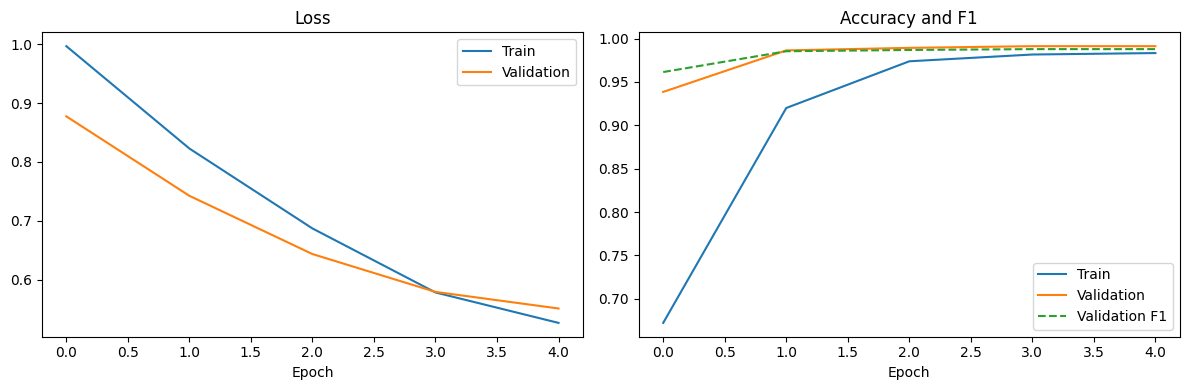

In [31]:
# Plot training results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train')
plt.plot(results['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_accuracy'], label='Train')
plt.plot(results['val_accuracy'], label='Validation')
plt.plot(results['val_f1'], label='Validation F1', linestyle='--')
plt.title('Accuracy and F1')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('images/ner_training_curves.png')
plt.show()

In [32]:
# Function to use the trained model for prediction
def predict_diseases(text, model, tokenizer):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    token_tags = [(token, 'O') for token in tokens]  # Initialize with 'O' tags
    
    # Process with BERT
    bert_input = prepare_bert_input(token_tags, tokenizer)
    
    # Convert to tensors
    input_ids = torch.tensor(bert_input['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(bert_input['attention_mask']).unsqueeze(0).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2).squeeze(0).cpu().numpy()
    
    # Map predictions back to tokens
    id2tag = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
    tagged_tokens = []
    word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()
    
    for i, word_idx in enumerate(word_ids):
        if word_idx is not None:  # Skip special tokens
            if i < len(predictions):
                prediction = id2tag[predictions[i]]
                if word_idx >= len(tagged_tokens):
                    tagged_tokens.append((tokens[word_idx], prediction))
                # Otherwise skip (word piece continuation)
    
    # Extract disease entities
    diseases = []
    current_disease = []
    
    for token, tag in tagged_tokens:
        if tag == 'B-DISEASE':
            if current_disease:
                diseases.append(' '.join(current_disease))
                current_disease = []
            current_disease.append(token)
        elif tag == 'I-DISEASE' and current_disease:
            current_disease.append(token)
        elif current_disease:
            diseases.append(' '.join(current_disease))
            current_disease = []
    
    if current_disease:
        diseases.append(' '.join(current_disease))
    
    return {
        'text': text,
        'tokens': tokens,
        'tagged_tokens': tagged_tokens,
        'extracted_diseases': diseases
    }

# Example usage:
test_text = "Patient has a history of hypertension and type 2 diabetes."
result = predict_diseases(test_text, model, tokenizer)
print(f"Text: {result['text']}")
print(f"Tagged tokens: {result['tagged_tokens']}")
print(f"Extracted diseases: {result['extracted_diseases']}")

# Save the final model
final_model_path = os.path.join('models', 'bert_ner_final')
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Save evaluation results and model information
with open(os.path.join(final_model_path, 'model_info.txt'), 'w') as f:
    f.write(f"Training completed with {num_epochs} epochs\n")
    f.write(f"Final validation accuracy: {results['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final validation F1 score: {results['val_f1'][-1]:.4f}\n")
    f.write(f"Best validation F1 score: {best_val_f1:.4f}\n")

Text: Patient has a history of hypertension and type 2 diabetes.
Tagged tokens: [('Patient', 'O'), ('has', 'O'), ('a', 'O'), ('history', 'O'), ('of', 'O'), ('hypertension', 'O'), ('and', 'O'), ('type', 'O'), ('2', 'O'), ('diabetes', 'O'), ('.', 'O')]
Extracted diseases: []


In [40]:
# Create a comprehensive metrics table
import pandas as pd
import numpy as np

# Extract the last epoch's validation metrics (already have accuracy and f1)
val_accuracy = results['val_accuracy'][-1]
val_f1 = results['val_f1'][-1]

# We need to calculate precision and recall
# Load validation data and get predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get predictions
        preds = torch.argmax(logits, dim=2).detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(label_ids)

# Flatten the predictions and labels for metrics calculation
all_preds_flat = np.concatenate([p.flatten() for p in all_preds])
all_labels_flat = np.concatenate([l.flatten() for l in all_labels])

# Remove padding (-100) tokens
mask = all_labels_flat != -100
all_preds_flat = all_preds_flat[mask]
all_labels_flat = all_labels_flat[mask]

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# For binary metrics, we'll treat disease tags (1 and 2) as positive class
binary_preds = (all_preds_flat > 0).astype(int)
binary_labels = (all_labels_flat > 0).astype(int)

# Calculate metrics
precision = precision_score(binary_labels, binary_preds)
recall = recall_score(binary_labels, binary_preds)
f1 = f1_score(binary_labels, binary_preds)
accuracy = accuracy_score(binary_labels, binary_preds)

# For AUC, we need probabilities
prob_preds = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get probability for disease tags (average of class 1 and 2)
        probs = torch.softmax(logits, dim=2)
        disease_probs = probs[:,:,1:].mean(dim=2).detach().cpu().numpy()
        prob_preds.append(disease_probs)

prob_preds_flat = np.concatenate([p.flatten() for p in prob_preds])
prob_preds_flat = prob_preds_flat[:len(binary_labels)]  # Match lengths

# Calculate AUC
auc_score = roc_auc_score(binary_labels, prob_preds_flat)

# Create metrics table
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC': [auc_score],
})

import pickle

# Save the metrics to a pickle file
with open('models/bert_ner_eval/ner_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_df, f)

with open('models/bert_ner_eval/binary_labels.pkl', 'wb') as f:
    pickle.dump(binary_labels, f)

with open('models/bert_ner_eval/prob_preds_flat.pkl', 'wb') as f:
    pickle.dump(prob_preds_flat, f)

In [ ]:
# zip the models directory
!zip -r models.zip models
!zip -r images.zip images

# download from colab
from google.colab import files

# download the models and images
files.download('models.zip')
files.download('images.zip')

%echo "Download complete. You can now use the trained model for predictions."